### Example of using the Bayesian optimisation package in 1D. This script utilises batch sampling, but not bounds reduction or sub-batch sampling.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as con
import sys
import os

sys.path.append('..')
import BOPackage

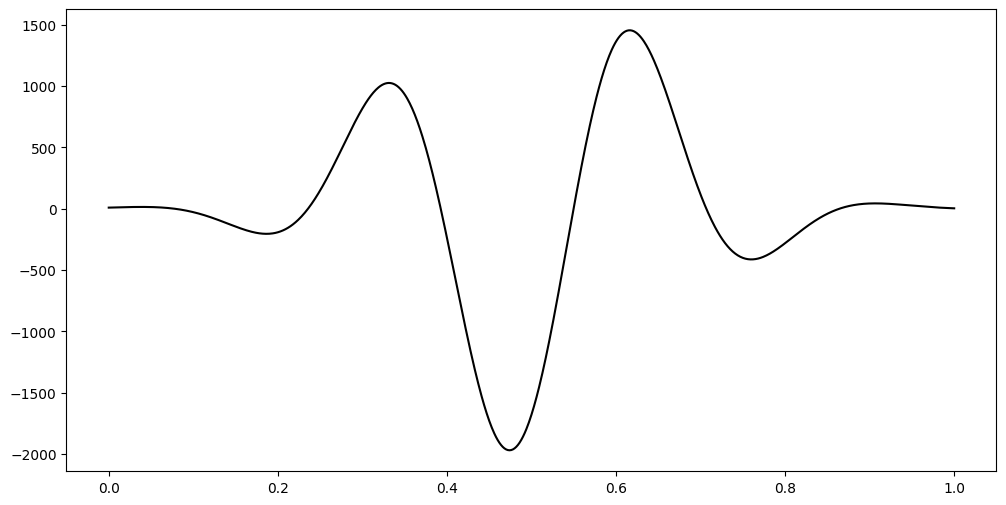

In [2]:
"""
Define the objective function.
"""

def ObjectiveFunction(x):
    x_centre = 0.5
    FWHM = 0.3
    width = FWHM / (2 * np.log(2))

    spatial_intensity =  np.exp(- ((x - x_centre) / width)**2)

    return 2000 * np.cos(20 * x) * spatial_intensity

X = np.linspace(0, 1, 1001, endpoint=True).reshape(1001, 1)

plt.figure(figsize=(12, 6))

plt.plot(X[:, 0], ObjectiveFunction(X), color='k')

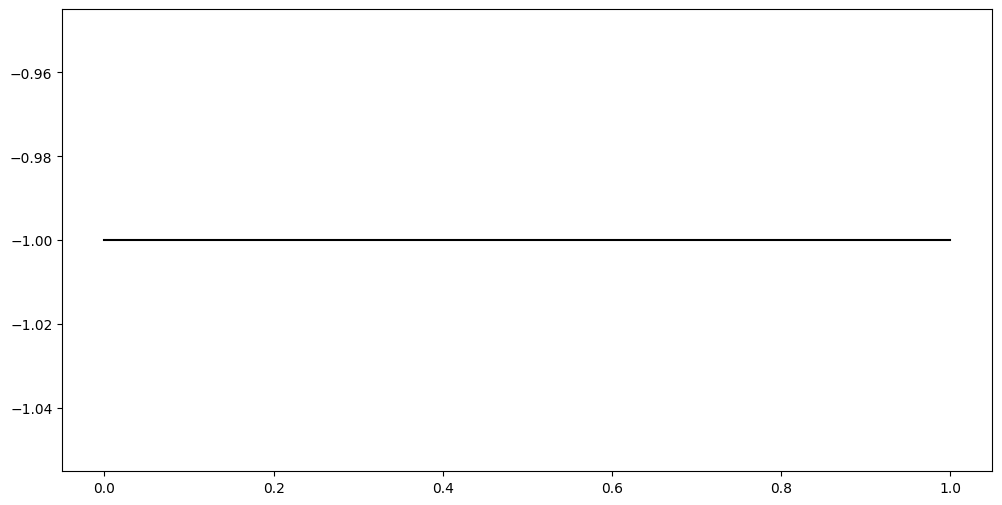

In [3]:
def PriorMeanFunction(X):
    return - np.ones(len(X)).reshape(len(X), 1)

plt.figure(figsize=(12, 6))

plt.plot(X[:, 0], PriorMeanFunction(X), color='k')

In [4]:
"""
Configure the optimiser.
"""
PriorMean = PriorMeanFunction
Kernel = BOPackage.RBF_Kernel_CPU
length_scale = 0.1             
noise = 1e-3                    # Relatively low noise

AcquisitionFunction = BOPackage.UpperConfidenceBound
max_kappa = 10                  # Maximum kappa value used in the acquisition function for the sub-batch
min_kappa = 0.1                 # Minimum kappa value used in the acquisition function for the sub-batch

bounds = np.array([[0, 1]])
acquisition_samples = 1000        # Number of random points in the domain to calculate the acqusition function value at. The point with the highest acquisition function value will be added to the raw_X for the batch

random_seed = None                # random seed for reproducability if wanted. 

# Create the object
bo = BOPackage.BO(PriorMeanFunction=PriorMean,
                  KernelFunction=Kernel, 
                  length_scale=length_scale, 
                  AcquisitionFunction=AcquisitionFunction, 
                  bounds=bounds, 
                  acquisition_samples=acquisition_samples,
                  random_seed=random_seed,
                  noise=noise)

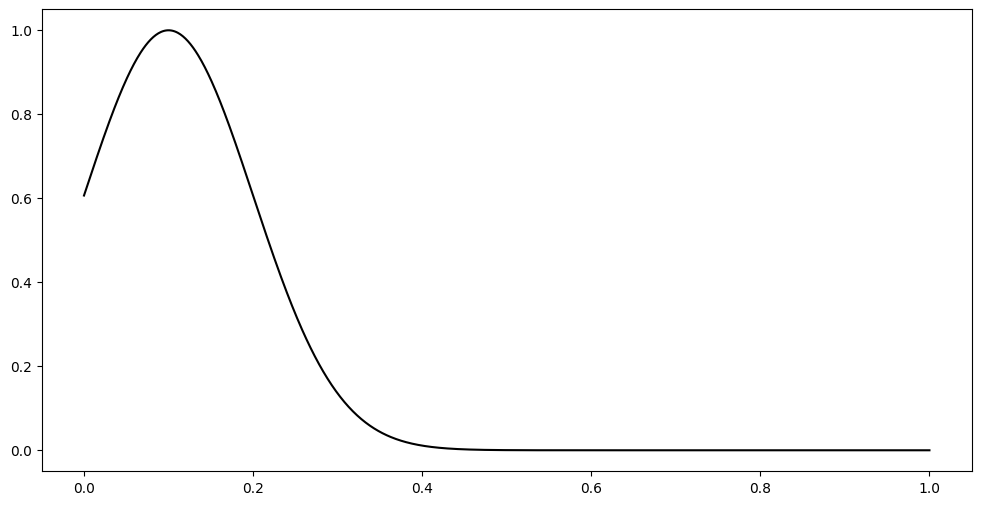

In [5]:
test_X = np.array([[0.1]])
kernel_example = bo.Kernel(test_X, X, length_scales=length_scale)

plt.figure(figsize=(12, 6))

plt.plot(X, kernel_example[0, :], color='k')

In [6]:
"""
Get first random batch and update the optimiser.
"""

raw_X = bo.GetRandomXBatch(batch_size=4)
raw_Y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_Y)

bo.X_data, bo.y_data

(array([[0.03296102],
        [0.44244123],
        [0.58169696],
        [0.19883688]]),
 array([[   14.99986324],
        [-1562.7843018 ],
        [ 1033.46284474],
        [ -193.50009428]]))

2025-04-01 16:13:26.245802: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-04-01 16:13:26.245838: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-01 16:13:26.245849: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-01 16:13:26.245912: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-01 16:13:26.245944: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


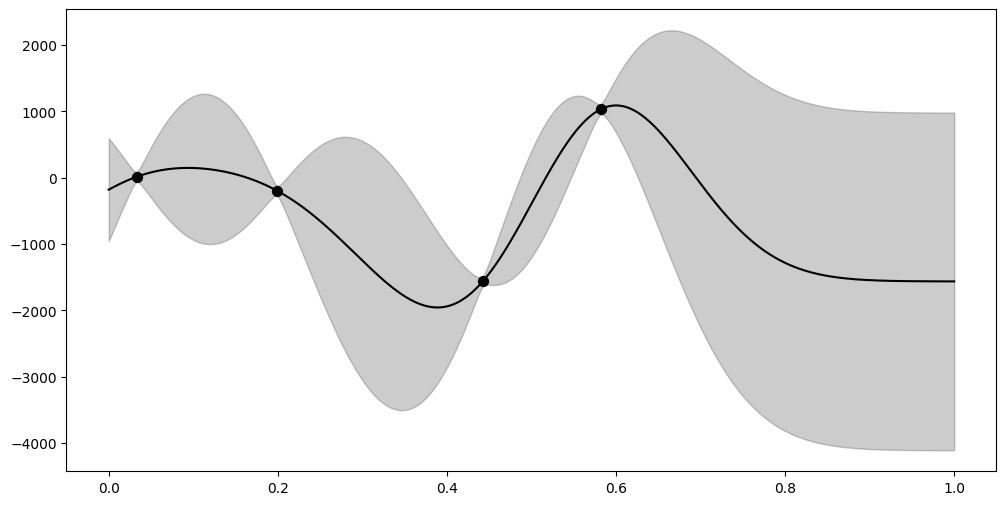

In [7]:
"""
Can then visualise the mean and variance over the parameter
using the true y values.
"""

mean, variance = bo.PredictMeanVariance(X, normalised=False)

plt.figure(figsize=(12, 6))

# Plot the mean and the confidence interval
plt.plot(X, mean, label='mean', color='k')
plt.fill_between(X[:,0], mean[:,0] - 1.96 * np.sqrt(variance[:,0]), mean[:,0] + 1.96 * np.sqrt(variance[:,0]), color = 'k', alpha=0.2, label = '95% confidence interval')

# Scatter plot of X_data and y_data
plt.scatter(bo.X_data, bo.y_data, s=50, color='k')

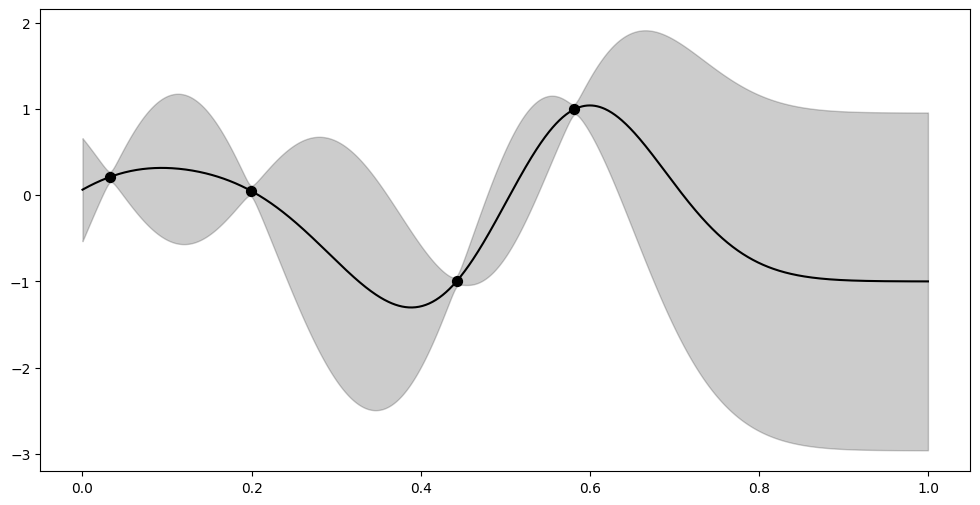

In [8]:
"""
Or can visualise the mean and variance over the parameter
using the normalised y values (which the code uses).
"""

if np.max(bo.y_data) - np.min(bo.y_data) != 0.0:
    normalised_y_data = 2 * (bo.y_data - np.min(bo.y_data)) / (np.max(bo.y_data) - np.min(bo.y_data)) - 1
else:
    normalised_y_data = bo.y_data

if bo.minimise is True:
    normalised_y_data = -normalised_y_data

normalised_mean, normalised_variance = bo.PredictMeanVariance(X, normalised=True)


plt.figure(figsize=(12, 6))

# Plot the mean and the confidence interval
plt.plot(X, normalised_mean, label='mean', color='k')
plt.fill_between(X[:,0], normalised_mean[:,0] - 1.96 * np.sqrt(normalised_variance[:,0]), normalised_mean[:,0] + 1.96 * np.sqrt(normalised_variance[:,0]), color = 'k', alpha=0.2, label = '95% confidence interval')

# Scatter plot of X_data and y_data
plt.scatter(bo.X_data, normalised_y_data, s=50, color='k')

<Figure size 1200x600 with 0 Axes>

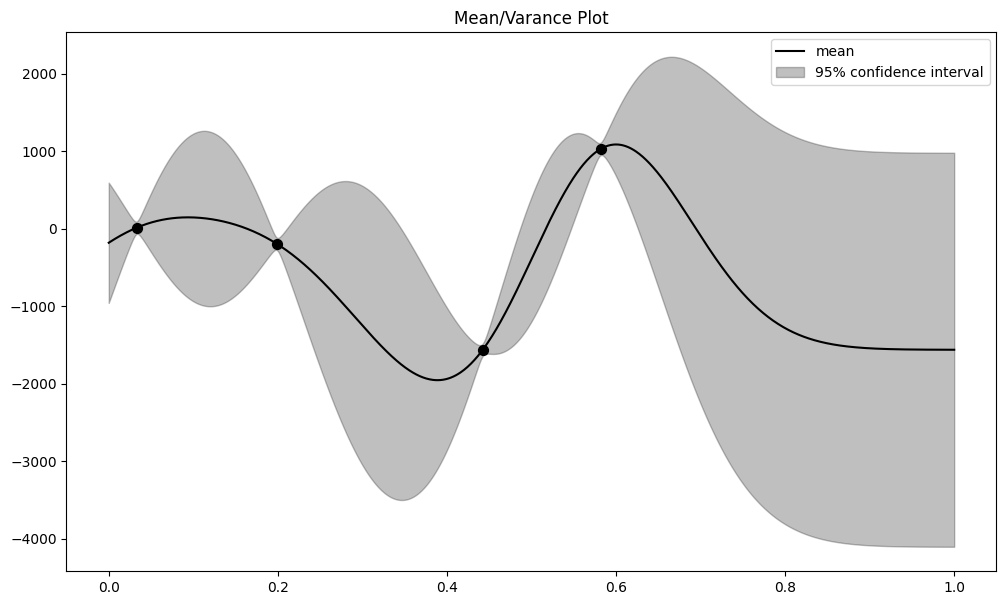

In [9]:
"""
Or can use the function provided by the package.
"""

BOPackage.SausagePlot(bo, normalised=False)

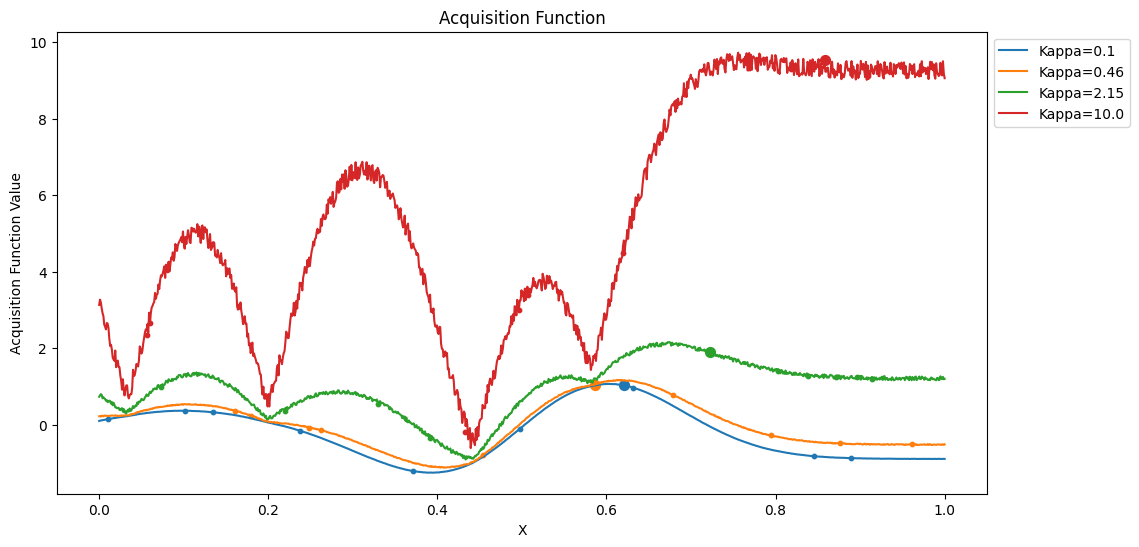

In [10]:
"""
Plot the Acquisition function for a range of kappas and demonstrate how the next point is selected.

'n_sample' random X values are selected and the one which returns the largest acqusition function value
is chosen for each kappa value. Assuming no 'sub batches' are used, there will be 'batch_size' kappa 
values and a point in X will be selected for each kappa value.
"""

raw_X = BOPackage.KappaAcquisitionFunctionPlot(bo, number_kappas=4, number_candidate_points=10, max_kappa=max_kappa, min_kappa=min_kappa)

<Figure size 1200x600 with 0 Axes>

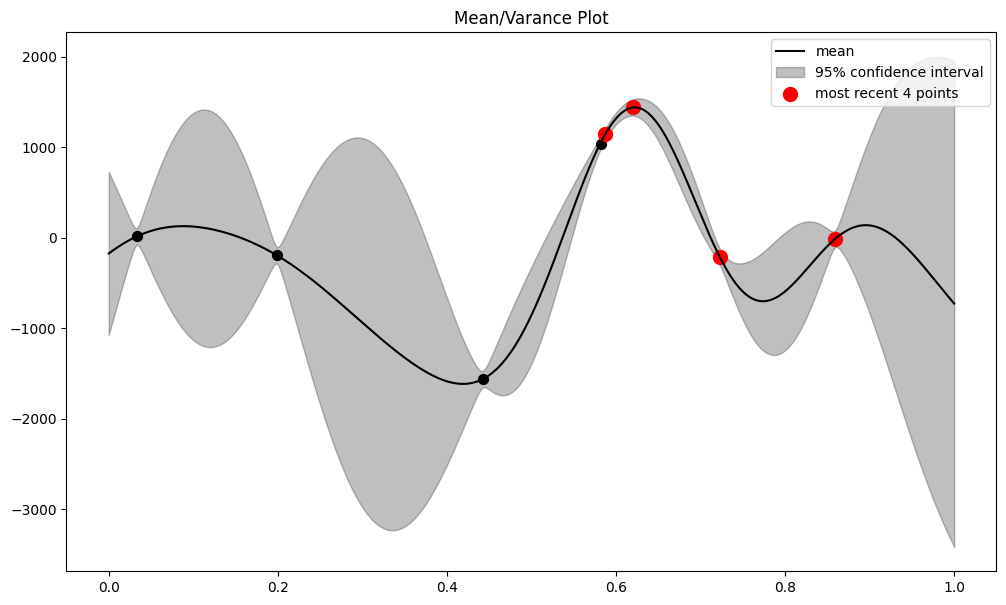

In [11]:
"""
Now select the next batch of X values using the acquisition function (not random) and update the optimiser.
"""

# batch_size = 4
# raw_X = bo.GetNextXBatch(batch_size=batch_size, max_kappa=max_kappa, min_kappa=min_kappa)
raw_Y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_Y)

BOPackage.SausagePlot(bo, highlight_recent=len(raw_X))

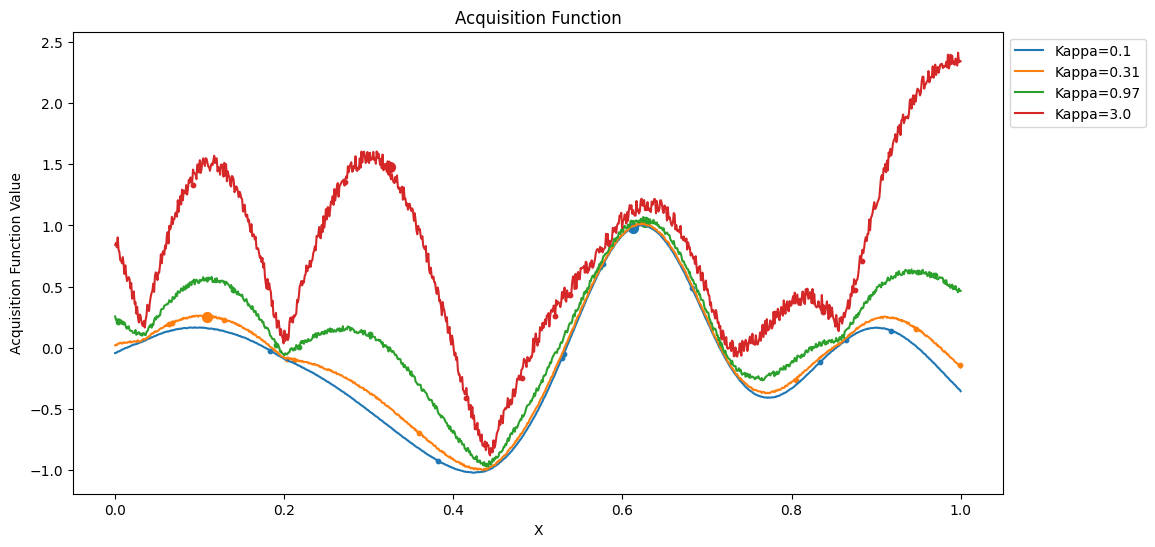

In [12]:
"""
Again lets looks at the acquisition function and how our next X set is selected.
"""
raw_X = BOPackage.KappaAcquisitionFunctionPlot(bo, number_kappas=4, number_candidate_points=10, max_kappa=3, min_kappa=0.1)

<Figure size 1200x600 with 0 Axes>

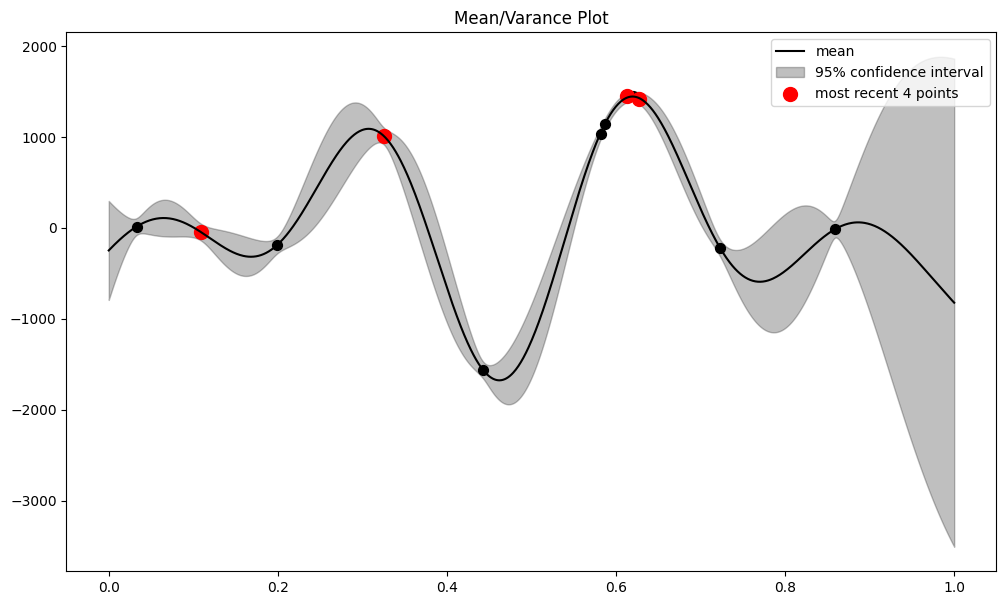

In [13]:
"""
Doing this again
"""
# batch_size = 4

# raw_X = bo.GetNextXBatch(batch_size=4, max_kappa=max_kappa, min_kappa=min_kappa)
raw_Y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_Y)

BOPackage.SausagePlot(bo, highlight_recent=len(raw_X))

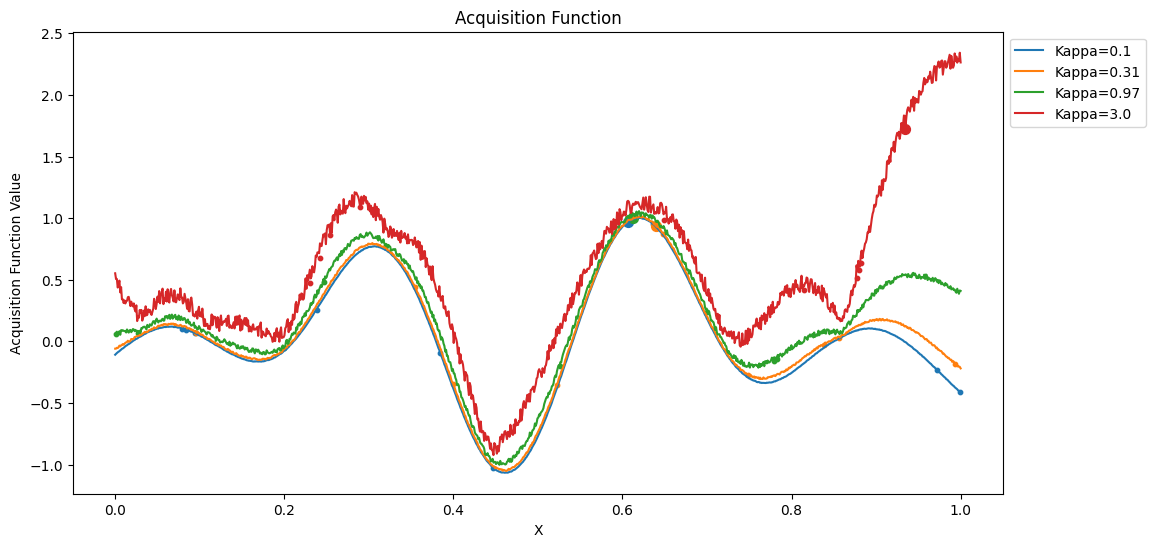

In [14]:
raw_X = BOPackage.KappaAcquisitionFunctionPlot(bo, number_kappas=4, number_candidate_points=10, max_kappa=3, min_kappa=0.1)

<Figure size 1200x600 with 0 Axes>

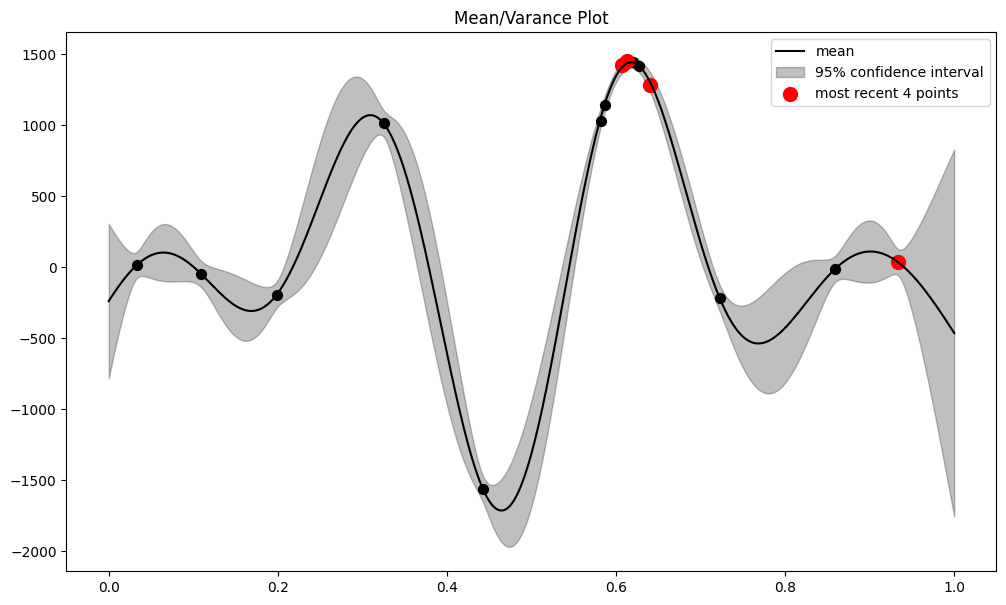

In [15]:
"""
Final example of doing this again.
"""
# batch_size = 4

# raw_X = bo.GetNextXBatch(batch_size=4, max_kappa=max_kappa, min_kappa=min_kappa)
raw_Y = ObjectiveFunction(raw_X)
bo.UpdateData(raw_X, raw_Y)

BOPackage.SausagePlot(bo, highlight_recent=len(raw_X))

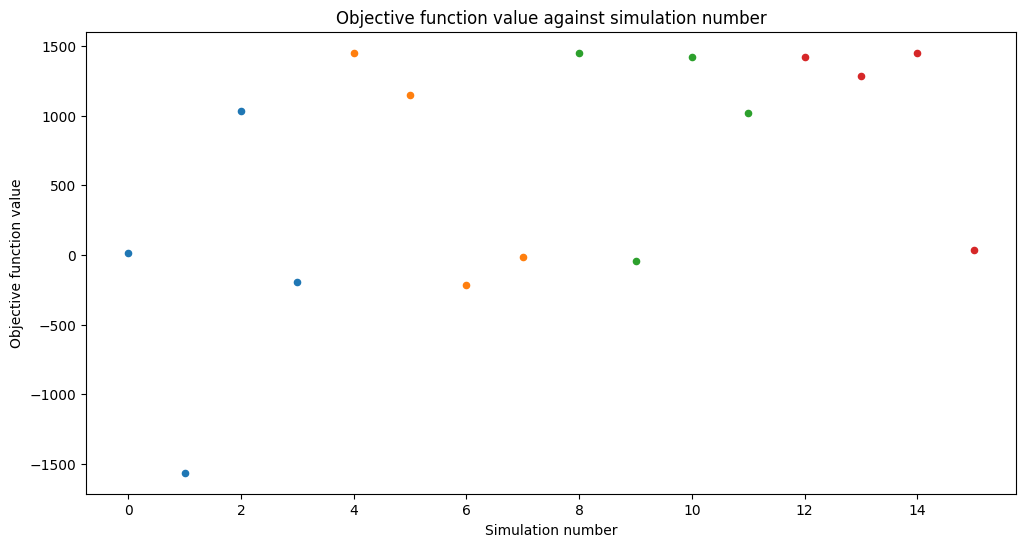

In [16]:
"""
See how the optimsation has progressed per iteration.
"""

BOPackage.PlotData(bo)